## Setting up the Imports

- numpy will be handy for mathematical functions.
- matplotlib will be used for the visualisation of the maze. 

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import plotly as pn
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


## Setting up the Maze

- Using matplotplib we use arrays filled with zeros (open space) and ones (walls) to build the maze structure. 
- In here, we also define the positions of the starting area, the end goal, and the sub goal. 

In [ ]:
# Initialising the maze
class Maze:
    def __init__(self, maze, start_position, goal_position, sub_goal_position):
        self.maze = maze
        
        self.maze_width = maze_struc.shape[1]           # rows of maze, also knows as x-azis. 
        self.maze_height = maze_struc.shape[0]          # columns of maze, also known as y-axis.

        self.start_position = start_position            # start position - S.
        self.goal_position = goal_position              # end goal position - E.
        self.sub_goal_position = sub_goal_position      # sub goal position - G.

    def show_maze(self):
        plt.figure(figsize=(5,5))

        plt.imshow(self.maze, cmap='Pastel1')

        # Placements for the start, end, and sub goal positions.
        plt.text(self.start_position[0], self.start_position[1], 'S', ha='center', va='center', color='green', fontsize=15)
        plt.text(self.goal_position[0], self.goal_position[1], 'E', ha='center', va='center', color='red', fontsize=15)
        plt.text(self.sub_goal_position[0], self.sub_goal_position[1], 'G', ha='center', va='center', color='blue', fontsize=15)

        # Add grid lines between every wall/space.
        plt.grid(color='black', linestyle='-', linewidth=0.5)
        plt.xticks(np.arange(0.5, self.maze.shape[1], 1))
        plt.yticks(np.arange(0.5, self.maze.shape[0], 1))
        plt.gca().set_xticks(np.arange(-0.5, self.maze.shape[1], 1), minor=True)
        plt.gca().set_yticks(np.arange(-0.5, self.maze.shape[0], 1), minor=True)
        plt.gca().grid(which='minor', color='grey', linestyle='-', linewidth=0.5)
        plt.gca().tick_params(which='both', length=0)

        plt.xlim(-0.45, self.maze.shape[1] - 0.5)
        plt.ylim(self.maze.shape[0] - 0.6, -0.4)

        # Hide the digits and labels from the plot visualistion. 
        plt.xticks([]), plt.yticks([])

        # Ensures the plot will visualise when running the code.
        plt.show()


# The layout of the 10x10 maze:
# 1 = wall.
# 0 = open area.
# (If wanted, we can later make another file where we can generate larger mazes like 100x100).
maze_struc = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 1, 0, 0, 0, 1, 0, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 0, 1, 1],
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
    [1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
    [1, 0, 1, 0, 0, 0, 0, 1, 0, 1],
    [1, 0, 0, 0, 1, 1, 0, 0, 0, 1],
    [1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
])

# Places the start, end, and sub goal at the correct coordinates (rows, columns).
maze = Maze(maze_struc, (1, 1), (7, 8), (3,5))

# Actually visualises the plot with matplotlib.
maze.show_maze()

## Setting up the Agent

This is where the logic of the agent come in:
- The agent can move in four directions. These are up, down, left, and right. 
- The q learning formula and logic will be applied to it. The parameters the agent will go off are:
    - the learning rate → decides how much new information overrides over information.
    - the discount factor → decides if the agent will prefer better rewards later on, or smaller awards right away
    - exploration rate → exploration vs. exploitation. This code works with a decay, over time it will proper exploitation over exploration in the maze.

- The agent is based on this formula of Q-Learning:

$$ Q(s, a) ← Q(s, a) + α [r + γ max(a') Q(s', a') - Q(s, a)] $$

In [20]:
# Actions the agent can take.
moves = [
   (-1, 0),         # Moving one step up.
   (1, 0),          # Moving one step down.
   (0, -1),         # Moving one step left.
   (0, 1)           # Moving one step right.
]

# Initialise the Q-Learning agent 
class QLearningAgent:
    def __init__(self, maze, learning_rate=0.1, discount_factor=0.9, exploration_start=1.0, exploration_end=0.01, num_episodes=100):
        
        # The table gets updated as new information is stored. 4 stands for the actions the agent can take. 
        self.q_table = np.zeros((maze.maze_height, maze.maze_width, 4)) 
         
        self.learning_rate = learning_rate          
        self.discount_factor = discount_factor      
        self.exploration_start = exploration_start  
        self.exploration_end = exploration_end
        self.num_episodes = num_episodes

    # Calculates the rate of exploration to exploitation over time -> start with a lot of exploration and eventually prefer exploitation.
    def get_exploration_rate(self, current_episode):
        exploration_rate = self.exploration_start * (self.exploration_end / self.exploration_start) ** (current_episode / self.num_episodes)
        return exploration_rate
    
    # Chooses what movement action to make. 
    def get_action(self, state, current_episode):
        exploration_rate = self.get_exploration_rate(current_episode)

        # Select an action for the given state either randomly (exploration) or using the Q-table (exploitation).
        if np.random.rand() < exploration_rate:
            return np.random.randint(4) 
        else:
            #Chooses the action with the highest Q-value for the given state.
            return np.argmax(self.q_table[state]) 
        
    # Updates the Q-values in the Q-table based on its actions and states.
    def update_q_table(self, state, action, next_state, reward):
        best_next_action = np.argmax(self.q_table[next_state])

        current_q_value = self.q_table[state][action]

        # Formula to update the Q-value based on the theory of the Q-Learning algorithm.
        new_q_value = current_q_value + self.learning_rate * (reward + self.discount_factor * self.q_table[next_state][best_next_action] - current_q_value)

        # Apply new Q-value for current action and state. 
        self.q_table[state][action] = new_q_value


## Setting up Agent in Maze

This cell will show the behaviour of the agent in a single episode and before it is trained with the Q-Learning algorithm.

- It DOES define the logic on the agent inside of the maze. In other words, giving the agent rewards and penalities for hitting walls and reaching the goal, respectively.
- So, it keeps track of the total reward.
- It also tracks the total steps the agent took.
- It also updates the Q-values as necessary.

Below, we first initialise the rewards or penalties the agent will receive based on its behaviour. Change as needed.

In [21]:
# Rewards.
goal_reward = 100
sub_goal_reward = 50

# Penalities.
wall_penalty = -10
step_penalty = -1

In [22]:
def qlearning_logic(agent, maze, current_episode, train=True):

    current_state = maze.start_position     # Agent starts at start position.
    path = [current_state]                  # Tracks the agent's current position.

    goal_reached = False                    # Tracks if the agent reached the goal.
    sub_reached = False                     # Tracks if the agent reached the sub goal.

    episode_reward = 0                      # Tracks the agent's total reward at the end of the episode.
    episode_step = 0                        # Tracks the agent's total steps at the end of the episode.
    
    while not goal_reached:

        # Decide the agent's next action based on the Q-Table.
        action = agent.get_action(current_state, current_episode)
        next_state = (current_state[0] + moves[action][0], current_state[1] + moves[action][1])

        # Give a penalty if a wall is hit.
        if (next_state[0] < 0 or next_state[0] >= maze.maze_height or 
            next_state[1] < 0 or next_state[1] >= maze.maze_width or 
            maze.maze[next_state[1]][next_state[0]] == 1):
            reward = wall_penalty
            next_state = current_state

        # Give a single-time reward if the sub-goal is reached.
        elif next_state == maze.sub_goal_position and not sub_reached:
            path.append(current_state)
            reward = sub_goal_reward
            sub_reached = True

        # Mark that the agent has reached the end and give a reward.
        elif next_state == maze.goal_position:
            path.append(current_state)
            reward = goal_reward
            goal_reached = True

        # Give a penalty every time the agent takes a step without reaching the final goal position.
        else:
            path.append(current_state)
            reward = step_penalty

        # Track the total steps and reward.
        episode_reward += reward
        episode_step += 1

        # Update Q-table if training is set to True.
        if train:
            agent.update_q_table(current_state, action, next_state, reward)

        # Update the agent's current position.
        current_state = next_state

    # Return total reward, steps, path, and whether the sub-goal was reached.
    return episode_reward, episode_step, path, sub_reached


## Visualising the Agent Test

- This version shows how the agent behaves in a single episode without any training whatsoever. 

In [23]:
# A helper function to visualise the maze.
def visualize_maze(maze, path, sub_goal_reached):
    plt.figure(figsize=(5, 5))
    plt.imshow(maze.maze, cmap='Pastel1')
    
    plt.text(maze.start_position[0], maze.start_position[1], 'S', ha='center', va='center', color='green', fontsize=15)
    plt.text(maze.goal_position[0], maze.goal_position[1], 'E', ha='center', va='center', color='red', fontsize=15)
    plt.text(maze.sub_goal_position[0], maze.sub_goal_position[1], 'G', ha='center', va='center', color='blue', fontsize=15)

    plt.grid(color='black', linestyle='-', linewidth=0.5)
    plt.xticks(np.arange(0.5, maze.maze.shape[1], 1))
    plt.yticks(np.arange(0.5, maze.maze.shape[0], 1))
    plt.gca().set_xticks(np.arange(-0.5, maze.maze.shape[1], 1), minor=True)
    plt.gca().set_yticks(np.arange(-0.5, maze.maze.shape[0], 1), minor=True)
    plt.gca().grid(which='minor', color='grey', linestyle='-', linewidth=0.5)
    plt.gca().tick_params(which='both', length=0)

    plt.xlim(-0.45, maze.maze.shape[1] - 0.5)
    plt.ylim(maze.maze.shape[0] - 0.6, -0.4)

    # Additionally show the path the agent took.
    for position in path:
        plt.text(position[0], position[1], "●", va='center', color='white', fontsize=8)

    plt.xticks([]), plt.yticks([])
    plt.show(block=True)


In [ ]:
# Shows a single episode of the agent (untrained).
def test_agent(agent, maze, num_episodes=1):
    episode_reward, episode_step, path, sub_reached = qlearning_logic(agent, maze, num_episodes, train=False)

    # Shows the path it took, total steps and total reward.
    print("Final Path:")
    for row, col in path:
        print(f"({row}, {col})-> ", end='')
    print("End Reached.")

    print("Total steps:", episode_step)
    print("Total reward:", episode_reward)

    # Visualize the maze with the agent's path.
    visualize_maze(maze, path, sub_reached)

    return episode_step, episode_reward

agent = QLearningAgent(maze)
test_agent(agent, maze)

### Heat Map

- Heat Map of untrained Agent through 5 episodes

In [ ]:
# Function to test the agent and generate a heat map of the visited tiles
def test_agent_with_heatmap(agent, maze, num_episodes=1):
    visit_count = np.zeros((maze.maze_height, maze.maze_width))

    for episode in range(num_episodes):
        _, _, path, _ = qlearning_logic(agent, maze, episode, train=False)
        for position in path:
            visit_count[position[1], position[0]] += 1  # Increment visit count for each position

    # Plot the heat map
    plt.figure(figsize=(5, 5))
    plt.imshow(visit_count, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Visit Count')
    plt.title('Heat Map of Tiles Visited by Agent')
    plt.show()

# Test the agent and generate the heat map
test_agent_with_heatmap(agent, maze, num_episodes=5)

## Training the Agent in the Maze

- We are now going to train the agent. By saving it's previous attempts and learning from the information it learned, it should improve its behaviour over time over the course of its assigned number of episodes.

In [96]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def train_agent(agent, maze, num_episodes=100):
    
    # Store the data for the rewards and the steps (for plotting purposes).
    episode_rewards = []
    episode_steps = []
    success_count = 0  # To count the number of successful episodes

    # Create a visit count matrix to store how many times the agent visited each tile.
    visit_count = np.zeros((maze.maze_height, maze.maze_width))

    # Loop over the number of episodes.
    for episode in range(num_episodes):
        episode_reward, episode_step, path, sub_reached = qlearning_logic(agent, maze, episode, train=True)
        
        # Check if the agent reached the goal
        if path[-1] == maze.goal_position:
            success_count += 1

        # Loop over the path the agent took and increment the visit count for each tile.
        for position in path:
            visit_count[position[1], position[0]] += 1  # Increment visit count for each position

        # Add the rewards and steps to their respective lists.
        episode_rewards.append(episode_reward)
        episode_steps.append(episode_step)

    # Calculate the moving average of rewards and steps to smooth out the data
    window_size = 10
    moving_avg_rewards = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')
    moving_avg_steps = np.convolve(episode_steps, np.ones(window_size)/window_size, mode='valid')

    # Calculate success rate
    success_rate = (success_count / num_episodes) * 100

    # Calculate variance in rewards and steps
    reward_variance = np.var(episode_rewards)
    steps_variance = np.var(episode_steps)

    # Create subplots
    fig = make_subplots(rows=1, cols=2, subplot_titles=('Reward per Episode', 'Steps per Episode'))

    # Add reward plot
    fig.add_trace(go.Scatter(x=list(range(num_episodes)), y=episode_rewards, mode='lines', name='Rewards'), row=1, col=1)
    fig.add_trace(go.Scatter(x=list(range(window_size-1, num_episodes)), y=moving_avg_rewards, mode='lines', name='Moving Avg Rewards'), row=1, col=1)
    fig.update_xaxes(title_text='Episode', row=1, col=1)
    fig.update_yaxes(title_text='Cumulative Reward', row=1, col=1)

    # Add steps plot
    fig.add_trace(go.Scatter(x=list(range(num_episodes)), y=episode_steps, mode='lines', name='Steps'), row=1, col=2)
    fig.add_trace(go.Scatter(x=list(range(window_size-1, num_episodes)), y=moving_avg_steps, mode='lines', name='Moving Avg Steps'), row=1, col=2)
    fig.update_xaxes(title_text='Episode', row=1, col=2)
    fig.update_yaxes(title_text='Steps Taken', row=1, col=2)

    # Plot the heat map
    plt.figure(figsize=(5, 5))
    plt.imshow(visit_count, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Visit Count')
    plt.title('Heat Map of Tiles Visited by Agent')
    plt.show()

    # Print the final reward and steps after training finished.
    final_reward = episode_rewards[-1]
    final_steps = episode_steps[-1]

    print(f"The final reward after training is: {final_reward}")
    print(f"The final steps after training are: {final_steps}")
    print(f"Success rate: {success_rate}%")
    print(f"Reward variance: {reward_variance}")
    print(f"Steps variance: {steps_variance}")

    # Show the plot
    fig.show()


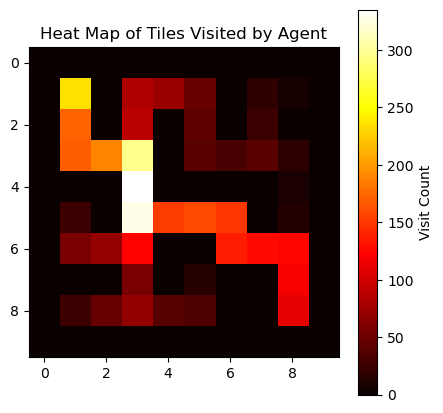

The final reward after training is: 137
The final steps after training are: 15


In [101]:
# Training the agent
train_agent(agent, maze, num_episodes=100)

## Final Trained Agent

- As you will probably see, if everything went well, the agent should now traverse through the maze the right way (fewest steps and highest rewards) after running the code cells.

In [ ]:
# Testing the agent after training
test_agent(agent, maze, num_episodes=100)

In [ ]:
# Test the agent and generate the heat map again
test_agent_with_heatmap(agent, maze, num_episodes=15)

### Animated showcase

- Finally, a last animated version to see it go through the maze after it learned the best possible route.

In [13]:
def animated_test_agent(agent, maze, num_episodes=100):
    last_episode_reward = 0
    last_episode_steps = 0
    last_episode_path = []

    for episode in range(num_episodes):
        episode_reward, episode_step, path, sub_reached = qlearning_logic(agent, maze, episode, train=False)
        
        # Capture the last episode's results
        if episode == num_episodes - 1:
            last_episode_reward = episode_reward
            last_episode_steps = episode_step
            last_episode_path = path

    print(f"Final reward from last episode: {last_episode_reward}")
    print(f"Final steps from last episode: {last_episode_steps}")

    return last_episode_reward, last_episode_steps, last_episode_path


In [ ]:
# Testing the agent after training and capturing the last episode's details
last_reward, last_steps, last_path = animated_test_agent(agent, maze, num_episodes=100)

# Animate only the last episode using the captured path
def animate_last_episode(agent, maze, path):
    fig, ax = plt.subplots(figsize=(5, 5))

    # Plot the initial maze positions.
    ax.imshow(maze.maze, cmap='Pastel1')
    ax.text(maze.start_position[0], maze.start_position[1], 'S', ha='center', va='center', color='green', fontsize=15)
    ax.text(maze.goal_position[0], maze.goal_position[1], 'E', ha='center', va='center', color='red', fontsize=15)
    sub_goal_marker = ax.text(maze.sub_goal_position[0], maze.sub_goal_position[1], 'G', ha='center', va='center', color='blue', fontsize=15)

    plt.grid(color='black', linestyle='-', linewidth=0.5)
    plt.xticks(np.arange(0.5, maze.maze.shape[1], 1))
    plt.yticks(np.arange(0.5, maze.maze.shape[0], 1))
    plt.gca().set_xticks(np.arange(-0.5, maze.maze.shape[1], 1), minor=True)
    plt.gca().set_yticks(np.arange(-0.5, maze.maze.shape[0], 1), minor=True)
    plt.gca().grid(which='minor', color='grey', linestyle='-', linewidth=0.5)
    plt.gca().tick_params(which='both', length=0)

    plt.xlim(-0.45, maze.maze.shape[1] - 0.5)
    plt.ylim(maze.maze.shape[0] - 0.6, -0.4)

    # Initialize the agent's position and direction marker.
    agent_marker, = ax.plot(maze.start_position[0], maze.start_position[1], "o", color='white', markersize=10)
    path_markers = []

    def update(frame):
        if frame < len(path):
            pos = path[frame]

            # Update agent marker position
            agent_marker.set_data(pos[0], pos[1])

            # Change the "G" sub-goal marker from blue to black when reached.
            if pos == maze.sub_goal_position:
                sub_goal_marker.set_color('black')

        # If it's the last frame (goal reached), plot the entire path.
        if frame == len(path) - 1:
            for (x, y) in path:
                marker, = ax.plot(x, y, ".", color='white', markersize=10)
                path_markers.append(marker)

        return agent_marker, sub_goal_marker, *path_markers

    # Animate the last episode path
    anim = FuncAnimation(fig, update, frames=len(path), interval=100, blit=True, repeat=False)

    print("Last Episode Path:")
    for row, col in path:
        print(f"({row}, {col})-> ", end='')
    print("End Reached")

    plt.xticks([]), plt.yticks([])
    plt.grid(color='black', linewidth=2)

    return anim

# Animate the last episode
anim_last_episode = animate_last_episode(agent, maze, last_path)

# Convert the animation to HTML for inline display in the notebook.
HTML(anim_last_episode.to_jshtml())
